# Load data, clean data, and perform EDA

In [2]:
# common libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import seaborn as sns

# Specific to this EDA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Import functions/moduls from this project.
import sys
sys.path.append("../src")

# assignment function imports
from custom_functions import download_kaggle_dataset
from custom_functions import impute_and_scale

Let's retrieve our core dataset of NBA player stats and salary data from Kaggle using the Kaggle API. Since it's used multpiple times it's called from a function. A full list of the Metric definitions for this dataset is available at the bottom of the notebook.

In [5]:
# Download the dataset, needs to authenticate to Kaggle
download_kaggle_dataset('jamiewelsh2/nba-player-salaries-2022-23-season', '../data') 

Dataset URL: https://www.kaggle.com/datasets/jamiewelsh2/nba-player-salaries-2022-23-season
Dataset 'jamiewelsh2/nba-player-salaries-2022-23-season' downloaded to '../data'


In [6]:
# Load CSV and look at data  
player_data = pd.read_csv('../data/nba_2022-23_all_stats_with_salary.csv')
player_data.head()

,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [7]:
# let's find the size of the data
rows, cols = player_data.shape
print('Rows: ', rows , 'Columns: ', cols)

Rows:  467 Columns:  52


In [8]:
# Let's inspect columns for data types and non-null counts.
player_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     467 non-null    int64  
 1   Player Name    467 non-null    object 
 2   Salary         467 non-null    int64  
 3   Position       467 non-null    object 
 4   Age            467 non-null    int64  
 5   Team           467 non-null    object 
 6   GP             467 non-null    int64  
 7   GS             467 non-null    int64  
 8   MP             467 non-null    float64
 9   FG             467 non-null    float64
 10  FGA            467 non-null    float64
 11  FG%            466 non-null    float64
 12  3P             467 non-null    float64
 13  3PA            467 non-null    float64
 14  3P%            454 non-null    float64
 15  2P             467 non-null    float64
 16  2PA            467 non-null    float64
 17  2P%            463 non-null    float64
 18  eFG%      

A few fields have missing values, especially in percentage-based shooting metrics like FT%, let's identify all of them.

In [10]:
# Convert to df
player_data_df = pd.DataFrame(player_data) 

#let's rename the first column 
player_data_df.rename(columns={'Unnamed: 0':'Index'}, inplace=True)

# count the columns by NULLS, filter to columns with > 0 NULLS
missing_counts = player_data_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]

print(missing_counts)

FG%      1
3P%     13
2P%      4
eFG%     1
FT%     23
TS%      1
3PAr     1
FTr      1
dtype: int64


Most missing values occur in percentage columns, which makes sense since players with very low or zero attempts may have undefined percentages.

Since we're going to handle missing values and will likely need to scale the data later, let's introduce a function to impute missing values using the median and also scale the data.

We're using the median because missing numeric data indicates the player didn't have enough data for the metric, so we'll assume they are at an average level.

We also have Player Name, Position, and Team, which are categorical/text values. For the final model, we won't need Team or Player Name since they should affect salary (in theory), but we will include Position by one-hot encoding it into the dataset

In [12]:
# transform and look at data
player_data_transform = impute_and_scale(player_data)
player_data_transform.head()

,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,3PA,...,VORP,Position_C,Position_PF,Position_PG,Position_PG-SG,Position_SF,Position_SF-PF,Position_SF-SG,Position_SG,Position_SG-PG
0,3.707088,1.915422,0.313407,1.232158,1.554622,2.707967,2.608452,0.256263,4.438107,3.811276,...,3.550533,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.639380,1.447096,-0.574364,-0.726051,0.244137,0.304907,0.554745,-0.521321,0.003895,0.180342,...,-0.375375,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.614551,1.915422,0.999412,0.049843,0.967525,1.038044,1.292485,-0.265176,0.231291,0.490300,...,0.563429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.370999,2.852073,0.273054,1.158263,1.638493,3.155995,3.007230,0.320299,1.368268,1.818690,...,2.953112,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.337798,1.915422,-0.049772,0.899632,1.648977,2.830156,2.229613,0.869182,1.140873,0.933097,...,2.867766,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


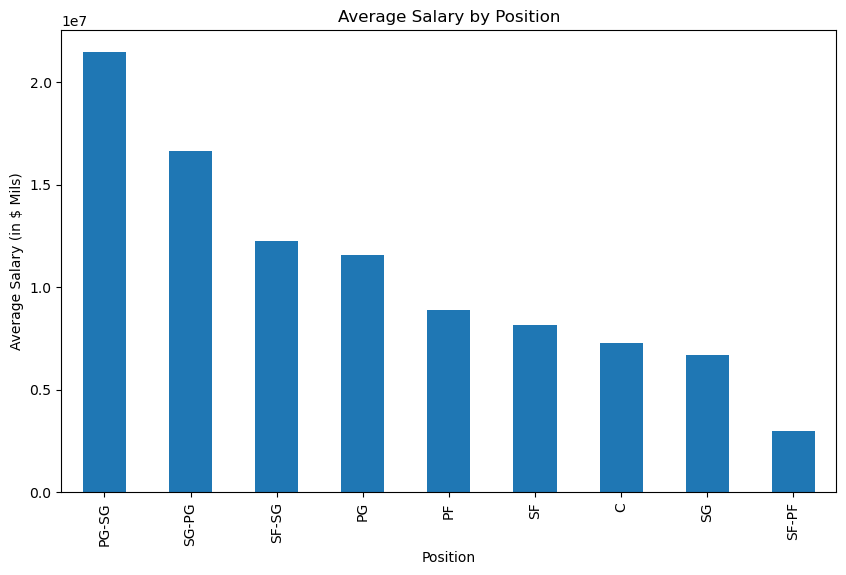

In [13]:
# let's look at the non-numeric feilds to check how they correspond to salary
# find average salary by position
position_avg_salary = player_data_df.groupby('Position')['Salary'].mean().sort_values(ascending=False)

# bar plot of averages
position_avg_salary.plot(kind='bar', figsize=(10,6))
plt.title('Average Salary by Position')
plt.xlabel('Position')
plt.ylabel('Average Salary (in $ Mils)')
plt.show()


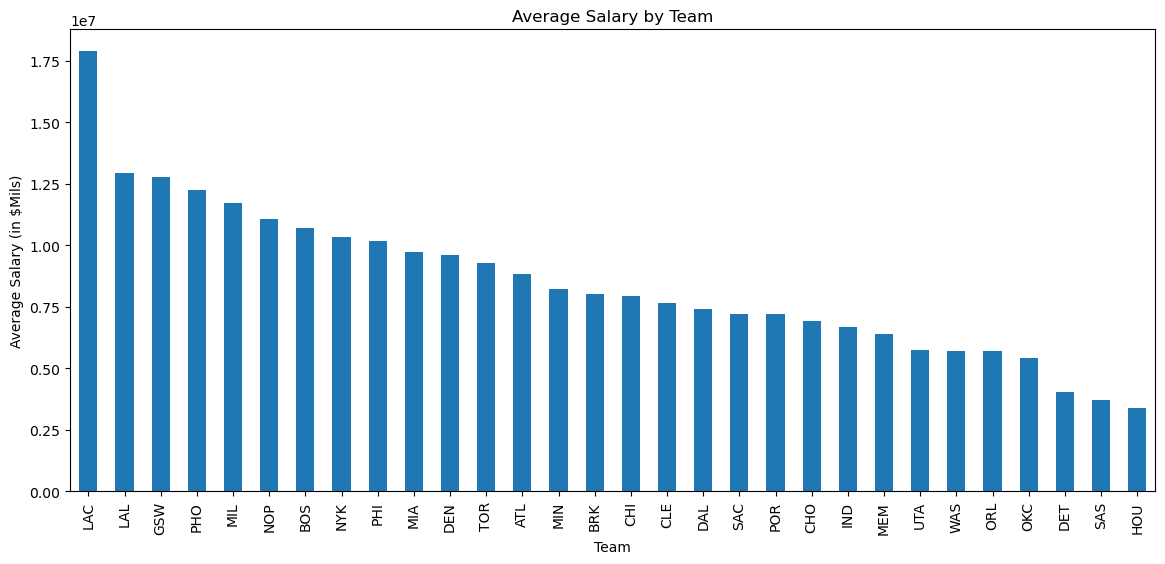

In [14]:
# let's look at how team correspnds to salary, we're giong to remove anythin with "/" since that indicates 
# the player was traded or waived during the season 
player_data_df_no_trades =  player_data_df[~player_data_df['Team'].str.contains('/', regex=False)]

# find average salary by team
team_avg_salary = player_data_df_no_trades.groupby('Team')['Salary'].mean().sort_values(ascending=False)

# bar plot of averages
team_avg_salary.plot(kind='bar', figsize=(14,6))
plt.title('Average Salary by Team')
plt.xlabel('Team')
plt.ylabel('Average Salary (in $Mils)')
plt.show()

Since teams can have a few have relatively low roster count (<15 typically), having a couple of higher earners can skew the team average.

Now lets look at basic data distribution for the numeric columns

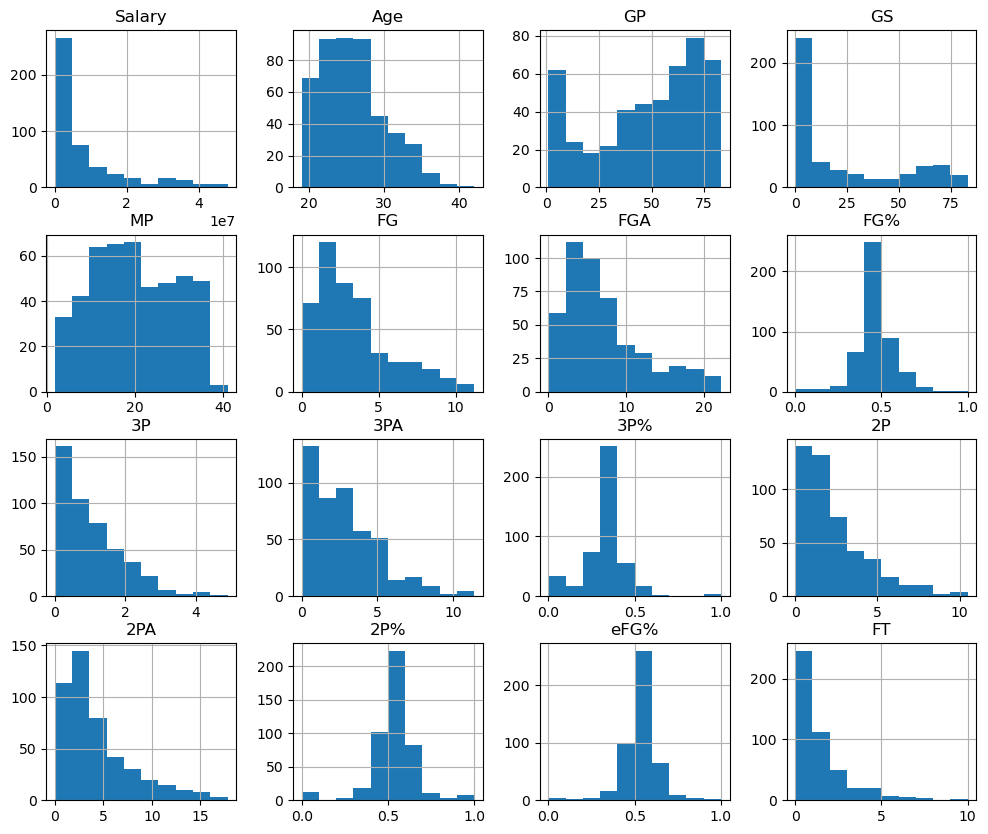

In [16]:
player_data_df.iloc[:,1:20].hist(bins=10, figsize=(12,10));

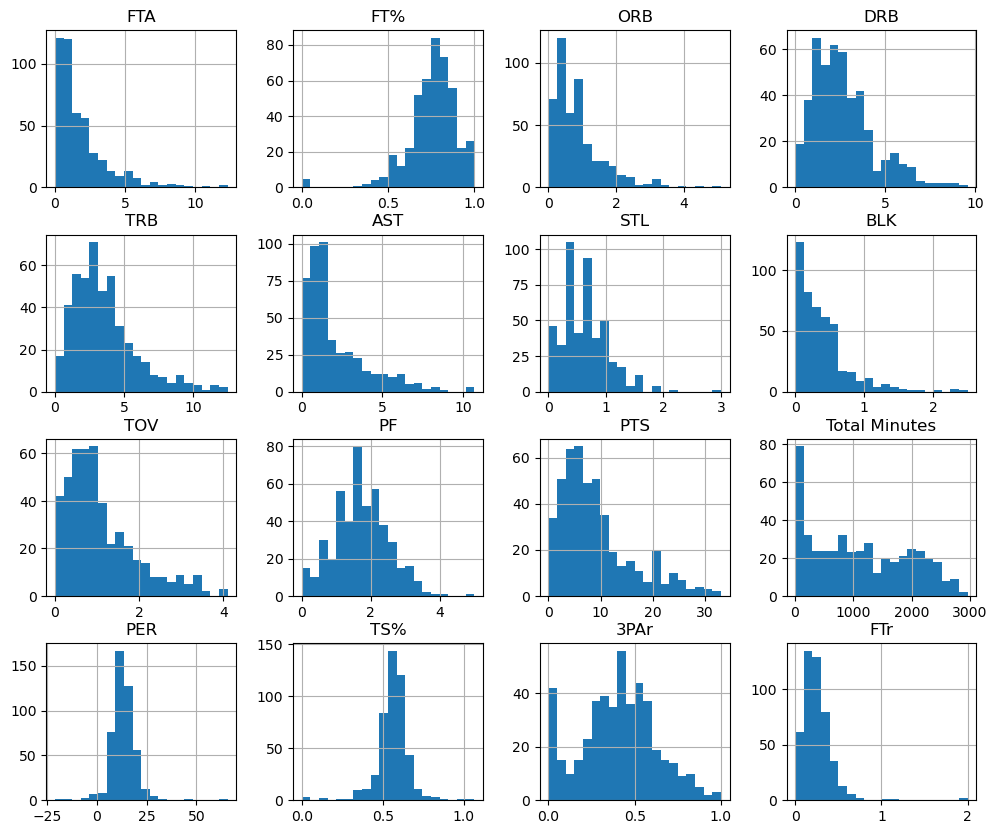

In [17]:
player_data_df.iloc[:,20:36].hist(bins=20, figsize=(12,10));

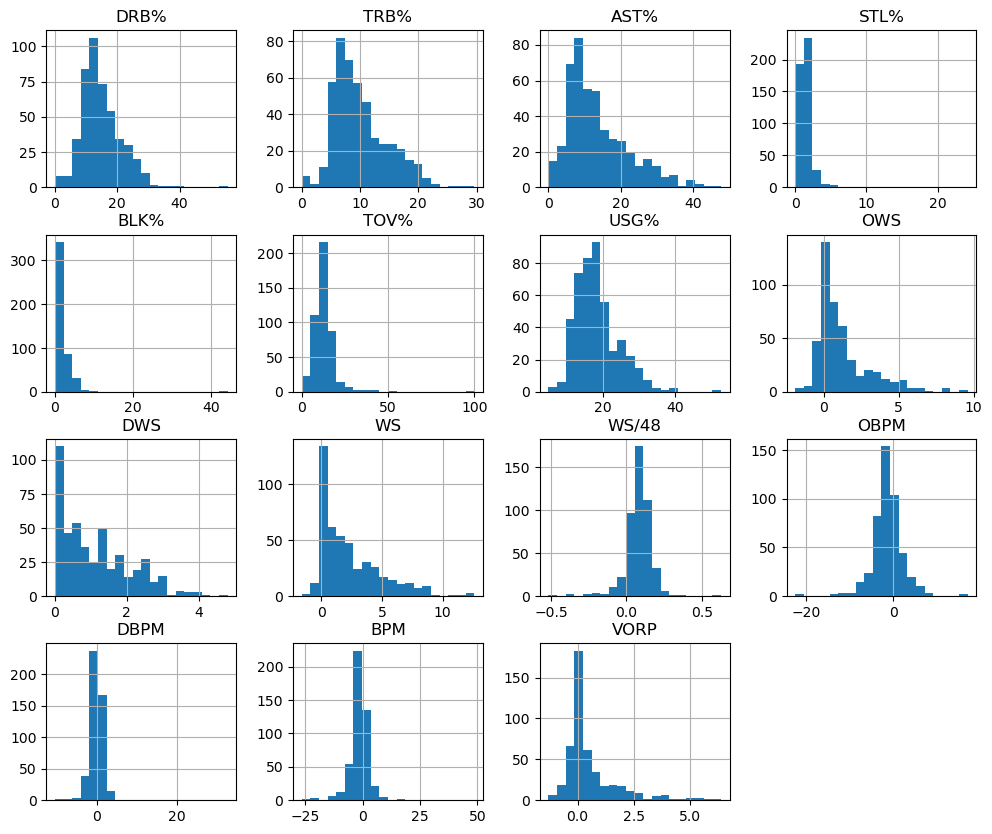

In [18]:
player_data_df.iloc[:, 37:].hist(bins=20, figsize=(12,10));

Most of the distriubtions are normal, with some being more poisson shaped. 

When thinking about what drives Salaries for NBA players, the immediate correlation one might suspect is to points. Let's see if that holds.  

<Axes: xlabel='PTS', ylabel='Salary'>

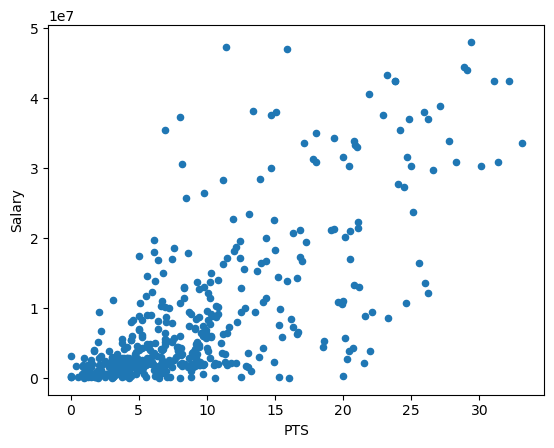

In [20]:
player_data_df.plot(kind='scatter', x='PTS', y='Salary')

There definitely appears to have a correlation, let's also look at another metric that might indicate salary, minutes played

<Axes: xlabel='MP', ylabel='Salary'>

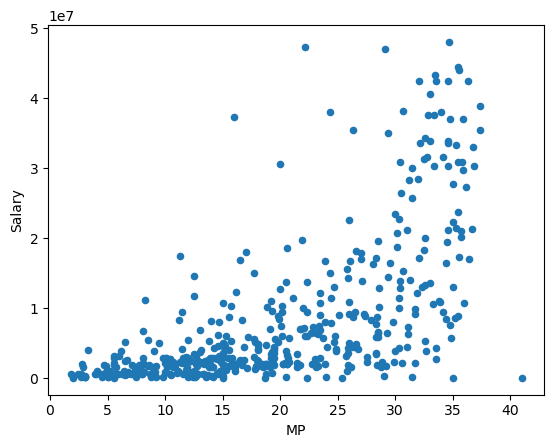

In [22]:
player_data_df.plot(kind='scatter', x='MP', y='Salary')

In [23]:
# To see how well the features correlate to salary, let's find the correlation coefficient between the attributes and salary
# going to use player_data_transform, since it already drops non-numeric columns
corr_matrix = player_data_transform.corr()

corr_matrix['Salary'].sort_values(ascending=False)

Salary            1.000000
PTS               0.727597
FG                0.720260
FGA               0.706393
2PA               0.681926
VORP              0.680339
2P                0.676406
FT                0.673772
FTA               0.668638
TOV               0.646808
MP                0.642099
WS                0.624664
GS                0.602267
AST               0.593971
OWS               0.582416
DRB               0.576596
DWS               0.566990
Total Minutes     0.565897
TRB               0.503633
3PA               0.491569
USG%              0.488063
OBPM              0.486816
3P                0.480239
STL               0.449517
AST%              0.447976
Age               0.416072
PER               0.411790
PF                0.406488
BPM               0.382346
GP                0.341707
BLK               0.301344
WS/48             0.275959
ORB               0.219490
TS%               0.160003
FT%               0.155322
Position_PG       0.131390
FTr               0.119755
F

Points is the highest Correlation, but there are also many more columns that are highly correlated. Something important to note, some of these metrics are going to have colinearity issues, since something like Feild Goals (FG), for example, directly creates the Points (PTS) metric. This will be something we probably need to deal with when modeling, regularization will probabaly be needed.  

<Axes: xlabel='FG', ylabel='PTS'>

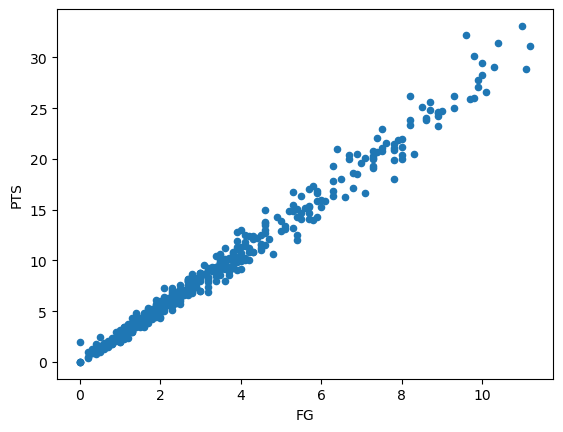

In [25]:
# To show possible colinearity, let's look at the correlation between feild goals and points 
player_data_df.plot(kind='scatter', x='FG', y='PTS')

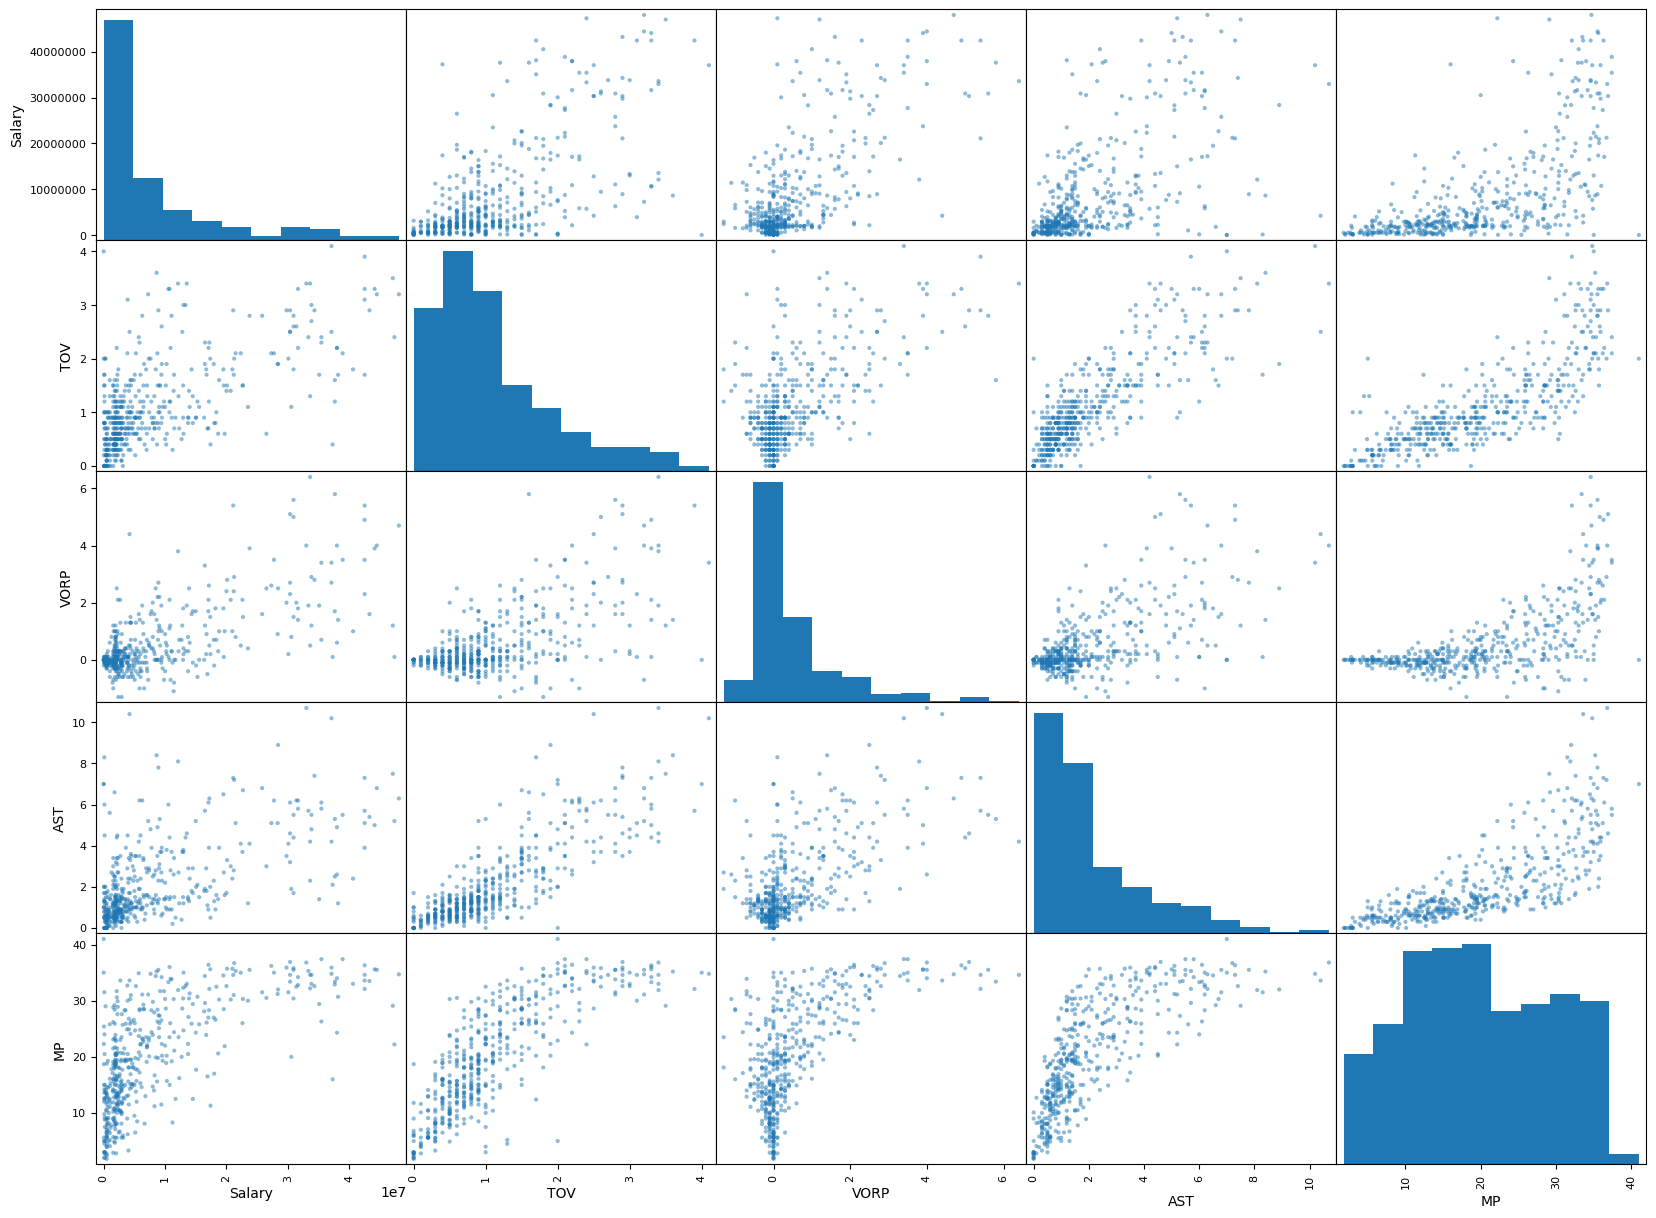

In [26]:
# While we're looking, let's also visualize a few correlations between some of the top non-point related attributes compared to salary
from pandas.plotting import scatter_matrix

attributes = ['Salary', 'TOV', 'VORP', 'AST', 'MP']

scatter_matrix(player_data_df[attributes], figsize=(20,15));

We can now condsider some Feature Engineering. Two big factors not considered here are whether the player was drafted, and if so, if the player is on a rookie contracts (which are set and non-negotiable for the first 4 years). To do this we need some further data.

In [28]:
# download draft data from kaggle
download_kaggle_dataset('benwieland/nba-draft-data', '../data') 

Dataset URL: https://www.kaggle.com/datasets/benwieland/nba-draft-data
Dataset 'benwieland/nba-draft-data' downloaded to '../data'


In [29]:
draft_data = pd.read_csv('../data/draft-data-20-years.csv')
draft_data.head() 

,Unnamed: 0,Rk,Pk,Tm,Player,College,Yrs,G,TOTMP,TOTPTS,...,WS/48,BPM,VORP,DraftYr,MPG,PPG,RPG,APG,playerurl,DraftYear
0,1,1,1,BRK,Derrick Coleman,Syracuse,15.0,781.0,25903.0,12884.0,...,0.119,1.4,22.3,1990,33.2,16.5,9.3,2.5,https://www.sports-reference.com/cbb/players/d...,1990
1,2,2,2,OKC,Gary Payton,Oregon State,17.0,1335.0,47117.0,21813.0,...,0.148,3.3,62.5,1990,35.3,16.3,3.9,6.7,https://www.sports-reference.com/cbb/players/g...,1990
2,3,3,3,DEN,Mahmoud Abdul-Rauf,LSU,9.0,586.0,15628.0,8553.0,...,0.077,-0.8,4.5,1990,26.7,14.6,1.9,3.5,https://www.sports-reference.com/cbb/players/m...,1990
3,4,4,4,ORL,Dennis Scott,Georgia Tech,10.0,629.0,17983.0,8094.0,...,0.089,0.2,9.9,1990,28.6,12.9,2.8,2.1,https://www.sports-reference.com/cbb/players/d...,1990
4,5,5,5,CHA,Kendall Gill,Illinois,15.0,966.0,29481.0,12914.0,...,0.078,0.1,15.8,1990,30.5,13.4,4.1,3.0,https://www.sports-reference.com/cbb/players/k...,1990


Let's Add some of the new data in and then save the final dataset for use in model testing.

In [31]:
# For the upcoming data joins, players that have multiple teams listed (ex Dal/BRK), we will just take the first team

# Create new column 'First_Team' with the team name before the '/'
player_data_df['First_Team'] = player_data_df['Team'].str.split('/', expand=True)[0]

# clean the team column, Charlotte has the wrong abbrevation in the source data
player_data_df['Team'] = player_data_df['Team'].replace('CHO', 'CHA')


# Merge the draft data
player_data_merged = player_data_df.merge(
    draft_data[['Player', 'DraftYear']], #only keeping these 2 for now, future enhancemnets could add further draft data
    left_on='Player Name',
    right_on='Player',
    how='left'
)


# using the new data let's add some new features on if they are still on a roookie scale contract or were undrafted
player_data_merged['Still_Rookie_contract']  = np.where(player_data_merged['DraftYear'] >= 2023 - 4, 1, 0)
player_data_merged['Undrafted_Flag'] =  np.where(player_data_merged['DraftYear'].isna(), 1, 0)


# now let's drop the redunadnt columns
player_data_final = player_data_merged.drop(['First_Team', 'Player', 'DraftYear'], axis='columns')


# now let's impute and scale and save the resulting dataset:
player_data_final = impute_and_scale(player_data_final)
# print(player_data_final.info())

player_data_final.to_csv('../data/player_data_final.csv', index=False)
player_data_final.head()

,Salary,Age,GP,GS,MP,FG,FGA,FG%,3P,3PA,...,Undrafted_Flag,Position_C,Position_PF,Position_PG,Position_PG-SG,Position_SF,Position_SF-PF,Position_SF-SG,Position_SG,Position_SG-PG
0,3.710871,1.916724,0.315571,1.234343,1.555489,2.709056,2.609888,0.259585,4.440903,3.814286,...,-0.724175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.643117,1.447935,-0.572167,-0.724496,0.247134,0.307385,0.557035,-0.515895,0.005832,0.182192,...,-0.724175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.618272,1.916724,1.001551,0.051648,0.969346,1.040098,1.294468,-0.260443,0.233271,0.492248,...,-0.724175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.374558,2.854301,0.275220,1.160425,1.639224,3.156825,3.008500,0.323448,1.370469,1.821063,...,-0.724175,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.341335,1.916724,-0.047594,0.901710,1.649691,2.831175,2.231207,0.870846,1.143030,0.935187,...,-0.724175,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, let's do a PCA to see how much variance is explained from the driving metrics

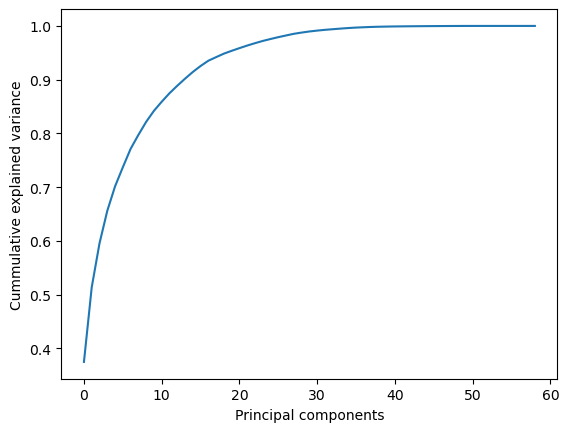

    Component  Cumulative Explained Variance
0           1                           0.37
1           2                           0.51
2           3                           0.60
3           4                           0.66
4           5                           0.70
5           6                           0.74
6           7                           0.77
7           8                           0.80
8           9                           0.82
9          10                           0.84
10         11                           0.86
11         12                           0.87
12         13                           0.89
13         14                           0.90
14         15                           0.91
15         16                           0.93
16         17                           0.94
17         18                           0.94
18         19                           0.95
19         20                           0.95


In [33]:

pca = PCA()  

# Fit PCA to the scaled data
player_data_PCA = pca.fit(np.array(player_data_final)) # with salary

cumulative_variance = np.cumsum(player_data_PCA.explained_variance_ratio_)

# plot the variance
plt.plot(cumulative_variance)
plt.xlabel('Principal components')
plt.ylabel('Cummulative explained variance')
plt.show()

# lets print the distriubtion of variance as well
var = pd.DataFrame({
    'Component': range(1, 21), #only looking at top 20 since >90% variance  is explained
    'Cumulative Explained Variance': np.round(cumulative_variance[:20], 2)
})
print(var)

The first 2 principal components explain over 50% of the variance, and the top 20 components explain over 95%, meaning much of the data’s structure can be captured with far fewer dimensions.

Now lets see if there's a specific metic driving the first two PC's:

In [35]:
# find explained variance by components
loadings = player_data_PCA.components_.T * np.sqrt(player_data_PCA.explained_variance_)

# Create a DataFrame of feature loadings for PC1 and PC2
loading_df = pd.DataFrame(loadings[:, :2], index=player_data_final.columns, columns=['PC1', 'PC2'])
print(loading_df.sort_values('PC1', ascending=False))  # order by PC1, can change to PCA2 

                            PC1       PC2
FG                     0.943116 -0.193427
PTS                    0.939806 -0.245685
2P                     0.912463  0.023537
2PA                    0.899832 -0.091865
FGA                    0.897317 -0.351036
MP                     0.890262 -0.236565
WS                     0.869178  0.116979
FTA                    0.866654 -0.073407
FT                     0.858764 -0.143768
VORP                   0.827953  0.007505
Total Minutes          0.826887 -0.175483
DRB                    0.826022  0.252012
TOV                    0.825121 -0.245410
GS                     0.806977 -0.133030
DWS                    0.804370  0.074472
OWS                    0.799993  0.127768
TRB                    0.773049  0.404545
Salary                 0.741527 -0.165431
OBPM                   0.733566  0.110087
AST                    0.728352 -0.403831
PER                    0.684087  0.370660
PF                     0.673644  0.117239
STL                    0.632511 -0

Interstingly, PC1 is dominated by volume-based metrics like Field Goals, Points, Minutes Played, and Usage Rate, suggesting the first PC favoirs offensive productivity. PC2 reflects efficiency and complementary contributions, with higher impaact from metrics like on Rebounding %, FG%, Blocks, and defensive stats.

The feature engineering also seems justified, as Undrafted_Flag has a significant negative impact on PC1.

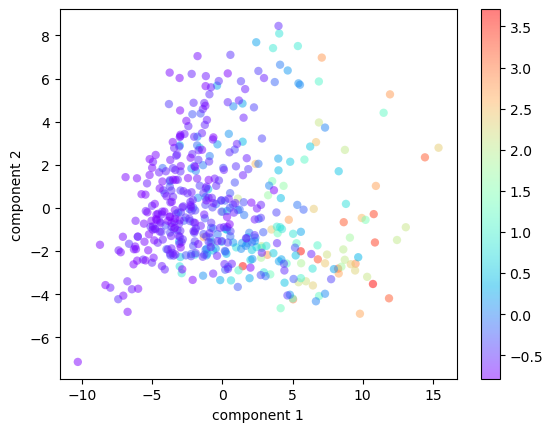

In [37]:
# let's plot two PC's and see how much the correspons to Salary
# PCA to 2 compenents
pca = PCA(2)  

# Fit PCA to the scaled data
player_data_PCA = pca.fit_transform(np.array(player_data_final))

plt.scatter(player_data_PCA[:, 0], player_data_PCA[:, 1],
            c=player_data_final['Salary'], edgecolor='none', alpha=0.5,
            cmap=matplotlib.colormaps['rainbow'])
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

# Appendix: Metric Definitions:

GP – Games Played

GS – Games Started

MP – Minutes Per Game

FG – Field Goals Made Per Game

FGA – Field Goals Attempted Per Game

FG% – Field Goal Percentage

3P – Three-Point Field Goals Made

3PA – Three-Point Field Goals Attempted

3P% – Three-Point Percentage

2P – Two-Point Field Goals Made

2PA – Two-Point Field Goals Attempted

2P% – Two-Point Percentage

eFG% – Effective Field Goal Percentage (adjusts FG% for three-pointers)

FT – Free Throws Made

FTA – Free Throws Attempted

FT% – Free Throw Percentage

ORB – Offensive Rebounds Per Game

DRB – Defensive Rebounds Per Game

TRB – Total Rebounds Per Game

AST – Assists Per Game

STL – Steals Per Game

BLK – Blocks Per Game

TOV – Turnovers Per Game

PF – Personal Fouls Per Game

PTS – Points Per Game

Total Minutes – Total Minutes Played in Season

PER – Player Efficiency Rating (advanced all-in-one metric)

TS% – True Shooting Percentage (accounts for FG, 3P, and FT)

3PAr – Three-Point Attempt Rate (3PA/FGA)

FTr – Free Throw Attempt Rate (FTA/FGA)

ORB% – Offensive Rebound Percentage

DRB% – Defensive Rebound Percentage

TRB% – Total Rebound Percentage

AST% – Assist Percentage

STL% – Steal Percentage

BLK% – Block Percentage

TOV% – Turnover Percentage

USG% – Usage Percentage (est. team plays used while on court)

OWS – Offensive Win Shares

DWS – Defensive Win Shares

WS – Total Win Shares

WS/48 – Win Shares per 48 Minutes

OBPM – Offensive Box Plus/Minus

DBPM – Defensive Box Plus/Minus

BPM – Overall Box Plus/Minus

VORP – Value Over Replacement Player